In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [10]:
data = pd.read_csv('Datos recogidos.csv')
t = np.array([1,3,6,9,12,20,40,60])

for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.iloc[3] = data.iloc[3] * 10
data.reset_index(drop=True, inplace=True)
data.insert(0, 'T0', 0)

In [ ]:
import numpy as np

class KineticMonteCarlo:
    def __init__(self, lattice_size, T, processes, time_array, time_factor = 1e-22):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.processes = processes  # dict: procesos y sus parámetros
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time = time_array[0]
        self.time_array = time_array
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {p: 0 for p in processes.keys()}
        self.events_history = {p: [] for p in processes.keys()}

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def calculate_transition_rates(self, site):
        rates = {}
        n_ij = self.count_occupied_neighbors(site)

        if "adsorption" in self.processes:
            e_ads = self.processes["adsorption"]["e_ads"]
            e_int_abs = self.processes["adsorption"].get("e_int_abs", 0)
            E_ads = e_int_abs * n_ij + e_ads
            k_ads = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
            rates["adsorption"] = k_ads

        if "desorption" in self.processes:
            e_des = self.processes["desorption"]["e_des"]
            e_int_des = self.processes["desorption"].get("e_int_des", 0)
            E_des = e_int_des * n_ij + e_des
            k_des = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))
            rates["desorption"] = k_des

        if "diffusion" in self.processes:
            e_diff = self.processes["diffusion"]["e_diff"]
            k_diff = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-e_diff / (self.k_b * self.T))
            rates["diffusion"] = k_diff

        return rates

    def select_event(self, rates):
        total_propensity = sum(rates.values())
        r = np.random.rand() * total_propensity
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None  # shouldn't happen

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            if not rates or sum(rates.values()) == 0:
                break  # No more events possible

            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            self.time += delta_t

            event_type = self.select_event(rates)
            if event_type == "adsorption":
                self.lattice[site] = 1
            elif event_type == "desorption" and self.lattice[site] == 1:
                self.lattice[site] = 0
            elif event_type == "diffusion":
                if self.lattice[site] == 1:
                    neighbors = [
                        (site[0] + dx, site[1] + dy)
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                    ]
                    vacant_neighbors = [s for s in neighbors if self.lattice[s] == 0]
                    if vacant_neighbors:
                        new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                        self.lattice[site], self.lattice[new_site] = 0, 1

            self.events_count[event_type] += 1
            for key in self.events_history:
                self.events_history[key].append(self.events_count[key])

        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

        return self.occupancy


### ***Test considerando todos los procesos***

```python

lattice_size = 70
T = 280
e_ads = -1.83
e_des = 1.23
e_diff = -0.579
e_int_abs = 0.8
e_int_des = 0.7
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

In [48]:

processes = {
    "adsorption": {"e_ads": -1.83, "e_int_abs": 0.8},
    "desorption": {"e_des": 1.23, "e_int_des": 0.3},
    "diffusion": {"e_diff": -0.579}
}
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size=70, T=280, processes=processes, time_array=time_array)
result = sim.run_simulation()


simulated_data = result.values()
plt.scatter(time_array, data.iloc[8],color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

KeyboardInterrupt: 

### ***Test sin desorción***

```python

lattice_size = 70
T = 300
e_ads = 0.09
e_diff = 0.294
e_int_abs = 0.1
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

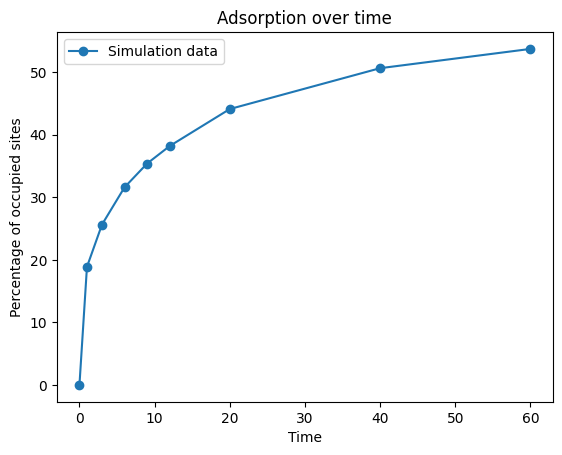

In [49]:
processes = {
    "adsorption": {"e_ads": 0.09, "e_int_abs": 0.1},
    "diffusion": {"e_diff": 0.294}
}
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

sim = KineticMonteCarlo(lattice_size=70, T=300, processes=processes, time_array=time_array)
result = sim.run_simulation()


simulated_data = result.values()
#plt.scatter(time_array, data.iloc[8],color = 'red', label='Experimental data')
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()